<a href="https://colab.research.google.com/github/zhizhuoli1/Best-Artorks-of-All-Time/blob/main/Deep%20Learning%20Models%20for%20Artist%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Goals: 
The project aims to use machine learning techniques to build a model which could give a guess of the painter of a given painting. Artworks of the 50 most influential artists are collected. The model would look into the colors and geometric patterns of the images for classification.

## 1. Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from keras.applications.vgg19 import VGG19
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## 2. Load and Prepare Data

### 2.1 Load the target variable - artist list

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Read the csv file
path = '/content/drive/MyDrive/Deep Learning/Models/artists.csv'
df = pd.read_csv(path)

Mounted at /content/drive


In [3]:
# id, name, years, genre, nationality, bio, wikipedia link, numbers of paintings
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [4]:
#50 artists in the file 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           50 non-null     int64 
 1   name         50 non-null     object
 2   years        50 non-null     object
 3   genre        50 non-null     object
 4   nationality  50 non-null     object
 5   bio          50 non-null     object
 6   wikipedia    50 non-null     object
 7   paintings    50 non-null     int64 
dtypes: int64(2), object(6)
memory usage: 3.2+ KB


In [5]:
#paintings - mean is 169 paintings with min of 24 and max of 877 
#there is clearly imbalance
df.describe()

,id,paintings
count,50.00000,50.000000
mean,24.50000,168.920000
std,14.57738,157.451105
min,0.00000,24.000000
25%,12.25000,81.000000
50%,24.50000,123.000000
75%,36.75000,191.750000
max,49.00000,877.000000


In [6]:
#no missing rows 
df.isna().sum()

id             0
name           0
years          0
genre          0
nationality    0
bio            0
wikipedia      0
paintings      0
dtype: int64

In [7]:
#take the variable name and number of paintings 
pt = df.sort_values('name').iloc[:,[1,7]]
pt = pt.reset_index(drop=True)

#replace 'space' as '_' for convenience and the image data folder is named with individual names as '_'
name = []
for n in pt['name']:
  name.append(n.replace(' ','_'))
pt['name'] = name

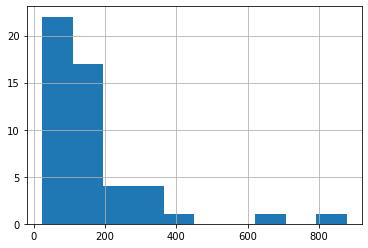

In [8]:
pt['paintings'].hist()
plt.show()

In [9]:
# since the class amount is not balanced, we need to assign class_weight when fitting the model
# So now create the class_weight
def class_weight(df):
    names = []
    classweight = {}
    for i in range(df.shape[0]):
        name = df.loc[i][0]
        paintings = df.loc[i][1]
        for i in range(paintings):
            names.append(name)      
    weights = compute_class_weight(class_weight='balanced',classes=df['name'].values, y = np.array(names))
    for i in range(len(df['name'].values)):
        classweight[i] = weights[i]
    return classweight

weight = class_weight(pt)

In [10]:
pt[:10]

,name,paintings
0,Albrecht_Dürer,328
1,Alfred_Sisley,259
2,Amedeo_Modigliani,193
3,Andrei_Rublev,99
4,Andy_Warhol,181
5,Camille_Pissarro,91
6,Caravaggio,55
7,Claude_Monet,73
8,Diego_Rivera,70
9,Diego_Velazquez,128


In [11]:
#exmaple - Caravaggio: more weight is assigned because less paintings Monet has here
weight[6]

3.0712727272727274

### 2.2 Load image data and prepare the data

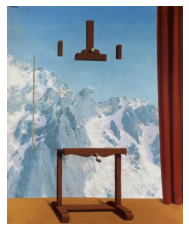

In [12]:
# browse image
img_path = '/content/drive/MyDrive/Deep Learning/Models/images'
artist = np.random.choice(pt['name'])
path = os.path.join(img_path,artist)
image_name = np.random.choice(os.listdir(path))
path = os.path.join(path, image_name)
#example of one painting
img = plt.imread(path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
# data augmentation
# create image generator
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                            shear_range = 0.5,
                                                            horizontal_flip = True,
                                                            validation_split=0.2)

In [14]:
target_size = (224, 224)
batch_size = 16
class_mode = 'categorical'

In [15]:
#split into training_set and validation set 
training_set = train_datagen.flow_from_directory(directory=img_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode=class_mode,
                                                subset='training')

Found 6786 images belonging to 50 classes.


In [16]:
validation_set = train_datagen.flow_from_directory(directory=img_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode=class_mode,
                                                subset='validation',
                                                shuffle = False)

Found 1669 images belonging to 50 classes.


## 3. CNN Models

### 3.1 ResNet50

In [17]:
model_resnet = keras.applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (224,224,3))
model_resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [46]:
def classifer(model):
    x = model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units = 500, activation = 'relu', kernel_initializer='he_normal')(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dense(units = 512, activation = 'relu')(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dense(units = 512, activation = 'relu')(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dense(units = 512, activation = 'relu')(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dense(units = 512, activation = 'relu')(x)
    #x = keras.layers.BatchNormalization()(x)
    y = keras.layers.Dense(units = 50, activation = 'softmax')(x)
    mod = keras.Model(inputs = model.input, outputs = y)
    return mod

In [48]:
clf = classifer(model_resnet)

In [49]:
clf.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001) , loss= 'categorical_crossentropy', metrics=['accuracy'])
early_stopping1 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [39]:
'''
for layer in clf.layers:
    layer.trainable = False

for layer in clf.layers[-2:]:
    layer.trainable = True
    '''

In [50]:
history1 = clf.fit(training_set, validation_data=validation_set, epochs=500, callbacks=[early_stopping1], class_weight= weight)

Epoch 1/500
425/425 [==============================] - 230s 533ms/step - loss: 3.4908 - accuracy: 0.1213 - val_loss: 5.7468 - val_accuracy: 0.0216
Epoch 2/500
425/425 [==============================] - 227s 534ms/step - loss: 3.0033 - accuracy: 0.2013 - val_loss: 3.9709 - val_accuracy: 0.1240
Epoch 3/500
425/425 [==============================] - 228s 536ms/step - loss: 2.7738 - accuracy: 0.2536 - val_loss: 4.3878 - val_accuracy: 0.0809
Epoch 4/500
425/425 [==============================] - 227s 533ms/step - loss: 2.5272 - accuracy: 0.2935 - val_loss: 5.1987 - val_accuracy: 0.0659
Epoch 5/500
425/425 [==============================] - 225s 531ms/step - loss: 2.3638 - accuracy: 0.3280 - val_loss: 3.7045 - val_accuracy: 0.1522
Epoch 6/500
425/425 [==============================] - 225s 530ms/step - loss: 2.2414 - accuracy: 0.3594 - val_loss: 5.8933 - val_accuracy: 0.0503
Epoch 7/500
425/425 [==============================] - 225s 530ms/step - loss: 2.0741 - accuracy: 0.3904 - val_loss: 4

In [56]:
clf.save('/content/drive/MyDrive/Deep Learning/Models/mod_resnet.h5')
#clf = keras.models.load_model('/content/drive/MyDrive/Deep Learning/Models/mod_resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [58]:
clf.evaluate(validation_set)

105/105 [==============================] - 45s 416ms/step - loss: 3.7134 - accuracy: 0.1612


[3.713428020477295, 0.16117435693740845]

In [59]:
clf = keras.models.load_model('/content/drive/MyDrive/Deep Learning/Models/mod_resnet.h5')

In [62]:
img_path

'/content/drive/MyDrive/Deep Learning/Models/images'

In [63]:
img_path

'/content/drive/MyDrive/Deep Learning/Models/images'

In [64]:
def predict_img(model):
    artist = random.choice(os.listdir(img_path))
    image = random.choice(os.listdir(os.path.join(img_path, artist)))
    predimg_path = os.path.join(img_path, artist, image)
    
    img = keras.preprocessing.image.load_img(predimg_path, target_size=target_size)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img)
    prob = round(np.amax(result),3)
    idx= np.argmax(result)
    
    show = plt.imread(predimg_path)
    plt.imshow(show)
    plt.axis('off')
    plt.show()
    return print('actural artist is {},\npredicted  artist is {},\nwith probability {}'.format(artist, pt['name'].values[idx],prob))

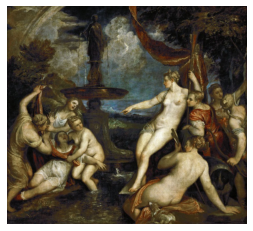

actural artist is Titian,
predicted  artist is Titian,
with probability 0.6069999933242798


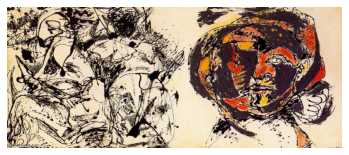

actural artist is Jackson_Pollock,
predicted  artist is Jackson_Pollock,
with probability 0.8360000252723694


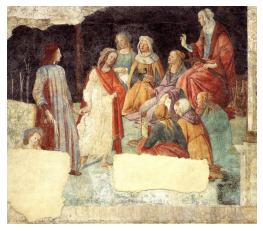

actural artist is Sandro_Botticelli,
predicted  artist is Sandro_Botticelli,
with probability 0.36899998784065247


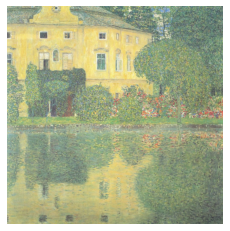

actural artist is Gustav_Klimt,
predicted  artist is Pieter_Bruegel,
with probability 0.19699999690055847


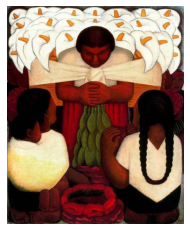

actural artist is Diego_Rivera,
predicted  artist is Diego_Rivera,
with probability 0.9819999933242798


In [80]:
for i in range(5):
    predict_img(clf)

The above result shows that we can predict the artist in certain accuracy level - the wrong predition of the fourth art was shown as low probability of 0.19, which is reasonable explanation because the model was not sure about this painting.

### 3.2 Inception V3

In [85]:
def classifer2(model):
    x = model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    y = keras.layers.Dense(50, activation='softmax')(x)
    mod = keras.Model(inputs = model.input, outputs = y)
    return mod

In [86]:
model2 = InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)
for layer in model2.layers[:249]:
   layer.trainable = False
for layer in model2.layers[249:]:
   layer.trainable = True

clf2 = classifer2(model2)

In [87]:
clf2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
inception_filepath = "/content/drive/MyDrive/"+'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, verbose=1, save_best_only=False)#, mode='max') 
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history2 = clf2.fit(training_set, epochs = 500, validation_data = validation_set,callbacks=[checkpoint,early_stopping2],verbose=1)

Epoch 1/500
425/425 [==============================] - 234s 539ms/step - loss: 3.5372 - accuracy: 0.1586 - val_loss: 2.9263 - val_accuracy: 0.2720

Epoch 00001: saving model to /content/drive/MyDrive/inceptionv3_-saved-model-01-loss-3.54.hdf5
Epoch 2/500
425/425 [==============================] - 228s 536ms/step - loss: 2.7337 - accuracy: 0.3114 - val_loss: 2.5033 - val_accuracy: 0.3631

Epoch 00002: saving model to /content/drive/MyDrive/inceptionv3_-saved-model-02-loss-2.73.hdf5
Epoch 3/500
425/425 [==============================] - 227s 534ms/step - loss: 2.2566 - accuracy: 0.4136 - val_loss: 2.2175 - val_accuracy: 0.4314

Epoch 00003: saving model to /content/drive/MyDrive/inceptionv3_-saved-model-03-loss-2.26.hdf5
Epoch 4/500
425/425 [==============================] - 226s 533ms/step - loss: 1.8771 - accuracy: 0.4997 - val_loss: 2.0756 - val_accuracy: 0.4638

Epoch 00004: saving model to /content/drive/MyDrive/inceptionv3_-saved-model-04-loss-1.88.hdf5
Epoch 5/500
425/425 [=======

In [ ]:
clf2 = keras.models.load_model("/content/drive/MyDrive/Deep Learning/Model/inceptionv3_-saved-model3-01-accuracy-0.90-val_accuracy-0.60.hdf5")

In [ ]:
# it is not as good as resnet model
for i in range(5):
    predict_img(clf2)

### 3.3 VGG19

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in vgg19.layers:
    layer.trainable = False
    
model3 = keras.Sequential()
model3.add(vgg19)
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(49,activation='sigmoid'))
#model2.build(input_shape = (None,128,128,3))

In [ ]:
early_stopping3 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
clf3 = model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')


In [ ]:
history3 = clf3.fit(training_set, validation_data=validation_set, epochs=50,callbacks=[early_stopping1],class_weight= weight)

In [ ]:
for i in range(10):
    predict_img(model)

### 3.4 EfficientNet

In [ ]:
#EfficientNet
import efficientnet.keras as efn

early_stopping4 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model4 = efn.EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(model4.output)
x = Dense(1024, activation="relu")(x)
predictions = Dense(49, activation="softmax")(x)

clf4 = Model(inputs = model4.input, outputs = predictions)

clf4.compile(optimizer= RMSprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
hisotry4 = model4.fit(training_set, validation_data = validation_set, epochs = 500, callbacks=[early_stopping4])